In [1]:
import os
import copy
import csv
import json
import time
import torch
import pandas as pd
import random
import datetime
import shutil
import numpy as np
from tqdm import tqdm
from PIL import Image
from itertools import chain
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import logging
import pickle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#유효성 증빙서류 저장 경로
save_path='C:/Users/1/106.지능형 양봉 데이터'

In [3]:
# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.DEBUG)

# log 출력 형식
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# log 출력
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


# log를 파일에 출력
logger.info(f'로그파일을 저장할 경로는 {save_path}입니다')
file_handler = logging.FileHandler(save_path+'/'+'LIFEISSUE_Model.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

2024-11-12 19:45:10,913 - root - INFO - 로그파일을 저장할 경로는 C:/Users/1/106.지능형 양봉 데이터입니다


In [4]:
# origin_path는 원천데이터(이미지데이터)가 저장되어있는 경로로 지정해야합니다.
# label_path는 라벨링데이터가 저장되어있는 경로로 지정해야합니다.

origin_path='C:/Users/1/106.지능형 양봉 데이터/01-1.정식개방데이터/Training/01.원천데이터'
label_path='C:/Users/1/106.지능형 양봉 데이터/01-1.정식개방데이터/Training/02.라벨링데이터'

# 데이터 불러오기

# 1.원천데이터, 라벨링데이터 경로에서 직접 불러오기

In [5]:
# 1.원천데이터 라벨링데이터 경로에서 직접불러오기


class DAnn_check():
    def __init__(self, img_root, label_root):
        self.img_root = img_root  # C:/Users/user/Desktop/test/원천데이터
        self.label_root = label_root  # C:/Users/user/Desktop/test/라벨링데이터

    def check(self):
        random_seed = 42
        random.seed(random_seed)
        dict_B = {}
        print('백묵명 음성 양성 Annotation 개수 추출')

        for i in os.listdir(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box'):
            logger.info('백묵병 데이터의 Annotation 개수를 측정합니다')
            if (i == '02.생애이슈(백묵병_음성)') | (i == '12.생애이슈(백묵병_양성)'):
                print(i)
                dict_B[f'num_of_{i}'] = 0

                # 디렉토리 내 파일 목록에서 각 클래스별로 최대 8000개의 샘플만 무작위로 선택
                sampled_files = random.sample(os.listdir(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i), min(8000, len(os.listdir(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i))))


                for j in tqdm(sampled_files):
                    with open(self.label_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i + '/' + j.split('.')[0] + '.json', 'r', encoding='UTF-8') as Bounding_d:
                        json_file_D = json.load(Bounding_d)
                        dict_B[f'num_of_{i}'] += len(json_file_D['ANNOTATION_INFO'])
                        ann_Bounding = dict_B.values()
            else:
                pass
        print(f'음성, 양성 데이터의 각각 Annotation 개수는 {ann_Bounding}개 입니다.')
        logger.info(f'백묵병 음성, 양성 데이터의 Annotation 개수는 {ann_Bounding}개 입니다.')
        return ann_Bounding


In [6]:
no_disease_ann, disease_ann=DAnn_check(img_root=origin_path,label_root=label_path).check()

2024-11-12 19:45:28,504 - root - INFO - 백묵병 데이터의 Annotation 개수를 측정합니다


백묵명 음성 양성 Annotation 개수 추출
02.생애이슈(백묵병_음성)


100%|██████████| 8000/8000 [00:50<00:00, 159.34it/s]
2024-11-12 19:46:19,333 - root - INFO - 백묵병 데이터의 Annotation 개수를 측정합니다


12.생애이슈(백묵병_양성)


100%|██████████| 8000/8000 [00:48<00:00, 166.60it/s]
2024-11-12 19:47:07,582 - root - INFO - 백묵병 음성, 양성 데이터의 Annotation 개수는 dict_values([79359, 77648])개 입니다.


음성, 양성 데이터의 각각 Annotation 개수는 dict_values([79359, 77648])개 입니다.


In [7]:
import os
import random
import json
from tqdm import tqdm
import logging
from PIL import Image
import torchvision.transforms as transforms

# Logger 설정
logger = logging.getLogger(__name__)

class D_Load():
    def __init__(self, img_root, label_root, class_list, Neg_ann, Pos_ann, resize=112):
        self.img_root = img_root
        self.label_root = label_root
        self.class_list = class_list
        self.Neg_ann = Neg_ann
        self.Pos_ann = Pos_ann
        self.trans_tensor = transforms.ToTensor()
        self.trans_resize = transforms.Resize((resize, resize))
    
    def D_Loading(self):
        random_seed = 42
        random.seed(random_seed)
        
        data_dict_D = {}
        return_list_D = []
        
        # 각 음성, 양성 이미지에 접근하여 최대 8000개씩만 로드
        for i in os.listdir(self.img_root + '/' + '실제데이터/' + 'Bounding Box'):  # i는 클래스명
            print(f'{i}_Loading 시작')
            logger.info(f'{i} 데이터 Loading을 시작합니다.')
            
            if i == '02.생애이슈(백묵병_음성)':
                logger.info(f'{i} 데이터 Loading을 시작합니다.')
                data_dict_D['음성'] = []
                sampled_files = random.sample(os.listdir(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i), self.Neg_ann)
                
                for j in tqdm(sampled_files):  # j는 각 이미지 파일명
                    with open(self.label_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i + '/' + j.split('.')[0] + '.json', 'r', encoding='UTF-8') as f:
                        jsonfile_D = json.load(f)
                        image_file_name = jsonfile_D['IMAGE']['IMAGE_FILE_NAME']
                        for k in range(len(jsonfile_D['ANNOTATION_INFO'])):  # 각 이미지 별로 Annotation info 가 몇 개가 있는지
                            x_data = self.trans_tensor(
                                self.trans_resize(
                                    Image.open(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i + '/' + j).crop(
                                        (jsonfile_D['ANNOTATION_INFO'][k]['XTL'], jsonfile_D['ANNOTATION_INFO'][k]['YTL'], jsonfile_D['ANNOTATION_INFO'][k]['XBR'], jsonfile_D['ANNOTATION_INFO'][k]['YBR']))))
                            data_dict_D['음성'].append([x_data, 0, image_file_name])
                            if len(data_dict_D['음성']) >= self.Neg_ann:
                                break
            
            elif i == '12.생애이슈(백묵병_양성)':
                logger.info(f'{i} 데이터 Loading을 시작합니다.')
                data_dict_D['양성'] = []
                sampled_files = random.sample(os.listdir(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i), self.Pos_ann)
                
                for l in tqdm(sampled_files):
                    with open(self.label_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i + '/' + l.split('.')[0] + '.json', 'r', encoding='UTF-8') as f:
                        jsonfile_D = json.load(f)
                        image_file_name = jsonfile_D['IMAGE']['IMAGE_FILE_NAME']
                        for m in range(len(jsonfile_D['ANNOTATION_INFO'])):
                            x_data = self.trans_tensor(
                                self.trans_resize(
                                    Image.open(self.img_root + '/' + '실제데이터' + '/' + 'Bounding Box' + '/' + i + '/' + l).crop(
                                        (jsonfile_D['ANNOTATION_INFO'][m]['XTL'], jsonfile_D['ANNOTATION_INFO'][m]['YTL'], jsonfile_D['ANNOTATION_INFO'][m]['XBR'], jsonfile_D['ANNOTATION_INFO'][m]['YBR']))))
                            data_dict_D['양성'].append([x_data, 1, image_file_name])
                            if len(data_dict_D['양성']) >= self.Pos_ann:
                                break
        
        for key in data_dict_D.keys():
            return_list_D += data_dict_D[key]
        
        return return_list_D

# 데이터 로드
dataset = D_Load(img_root=origin_path, label_root=label_path, Neg_ann=8000, Pos_ann=8000, class_list=['LA_NEG', 'LA_POS']).D_Loading()
logger.info('데이터 로딩이 끝났습니다.')


2024-11-12 19:47:40,522 - __main__ - INFO - 02.생애이슈(백묵병_음성) 데이터 Loading을 시작합니다.
2024-11-12 19:47:40,523 - __main__ - INFO - 02.생애이슈(백묵병_음성) 데이터 Loading을 시작합니다.


02.생애이슈(백묵병_음성)_Loading 시작


100%|██████████| 8000/8000 [05:16<00:00, 25.26it/s]
2024-11-12 19:52:57,219 - __main__ - INFO - 12.생애이슈(백묵병_양성) 데이터 Loading을 시작합니다.
2024-11-12 19:52:57,219 - __main__ - INFO - 12.생애이슈(백묵병_양성) 데이터 Loading을 시작합니다.


12.생애이슈(백묵병_양성)_Loading 시작


100%|██████████| 8000/8000 [05:47<00:00, 22.99it/s]
2024-11-12 19:58:45,191 - __main__ - INFO - 데이터 로딩이 끝났습니다.


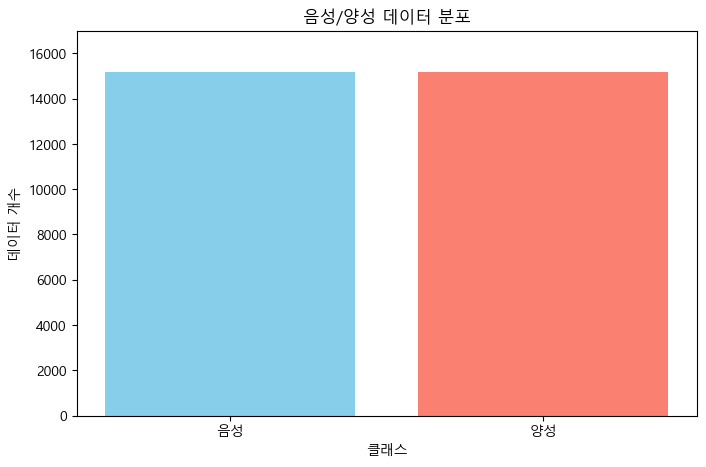

클래스 0: W 평균 - 0.0003
클래스 0: G 평균 - 1.0000
클래스 0: B 평균 - 0.0026
클래스 0: W 중앙값 - 0.0000
클래스 0: G 중앙값 - 1.0000
클래스 0: B 중앙값 - 0.0000
클래스 0: W 표준편차 - 0.0042
클래스 0: G 표준편차 - 0.0000
클래스 0: B 표준편차 - 0.0110
클래스 1: W 평균 - 0.2002
클래스 1: G 평균 - 0.9962
클래스 1: B 평균 - 0.1517
클래스 1: W 중앙값 - 0.0000
클래스 1: G 중앙값 - 1.0000
클래스 1: B 중앙값 - 0.0000
클래스 1: W 표준편차 - 0.3568
클래스 1: G 표준편차 - 0.0384
클래스 1: B 표준편차 - 0.3352


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 설정
plt.rcParams['axes.unicode_minus'] = False  # 한글 사용 시 마이너스 기호 깨짐 방지

# 데이터 구조 이해 및 샘플링 확인 (EDA)
def perform_eda(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]

    # 라벨별 데이터 개수 확인
    unique_labels, counts = np.unique(labels, return_counts=True)

    # 막대 그래프 시작
    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, tick_label=['음성', '양성'], color=['skyblue', 'salmon'])
    plt.xlabel('클래스')
    plt.ylabel('데이터 개수')
    plt.title('음성/양성 데이터 분포')
    plt.ylim(0, 17000)
    plt.show()

    for label in np.unique(labels):
        label_items = [item[0] for item in dataset if item[1] == label]
        w_means = []
        g_means = []
        b_means = []
        w_medians = []
        g_medians = []
        b_medians = []
        w_stds = []
        g_stds = []
        b_stds = []

        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            r_channel = img_array[0].flatten()
            g_channel = img_array[1].flatten()
            b_channel = img_array[2].flatten()

            # 흰색 조건: 모든 RGB 값이 0.85 이상인 경우 1, 그렇지 않으면 0
            w_channel = np.where((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85), 1, 0)
            # 블랙 조건: 모든 RGB 값이 0.15 이하인 경우 1, 그렇지 않으면 0
            b_channel = np.where((r_channel <= 0.15) & (g_channel <= 0.15) & (b_channel <= 0.15), 1, 0)
            # 회색 조건: 흰색도 아니고 블랙도 아닌 경우 1, 그렇지 않으면 0
            g_channel = np.where(~((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85)) &
                                 ~((r_channel <= 0.15) & (g_channel <= 0.15) & (b_channel <= 0.15)), 1, 0)

            # 평균, 중앙값, 표준편차 계산 시 빈 배열 예외 처리
            if w_channel.size > 0:
                w_means.append(np.mean(w_channel))
                w_medians.append(np.median(w_channel))
                w_stds.append(np.std(w_channel))
            if g_channel.size > 0:
                g_means.append(np.mean(g_channel))
                g_medians.append(np.median(g_channel))
                g_stds.append(np.std(g_channel))
            if b_channel.size > 0:
                b_means.append(np.mean(b_channel))
                b_medians.append(np.median(b_channel))
                b_stds.append(np.std(b_channel))

        # 각 통계량 출력
        print(f"클래스 {label}: W 평균 - {np.mean(w_means):.4f}" if w_means else "데이터 없음")
        print(f"클래스 {label}: G 평균 - {np.mean(g_means):.4f}" if g_means else "데이터 없음")
        print(f"클래스 {label}: B 평균 - {np.mean(b_means):.4f}" if b_means else "데이터 없음")

        print(f"클래스 {label}: W 중앙값 - {np.median(w_medians):.4f}" if w_medians else "데이터 없음")
        print(f"클래스 {label}: G 중앙값 - {np.median(g_medians):.4f}" if g_medians else "데이터 없음")
        print(f"클래스 {label}: B 중앙값 - {np.median(b_medians):.4f}" if b_medians else "데이터 없음")

        print(f"클래스 {label}: W 표준편차 - {np.mean(w_stds):.4f}" if w_stds else "데이터 없음")
        print(f"클래스 {label}: G 표준편차 - {np.mean(g_stds):.4f}" if g_stds else "데이터 없음")
        print(f"클래스 {label}: B 표준편차 - {np.mean(b_stds):.4f}" if b_stds else "데이터 없음")

perform_eda(dataset)


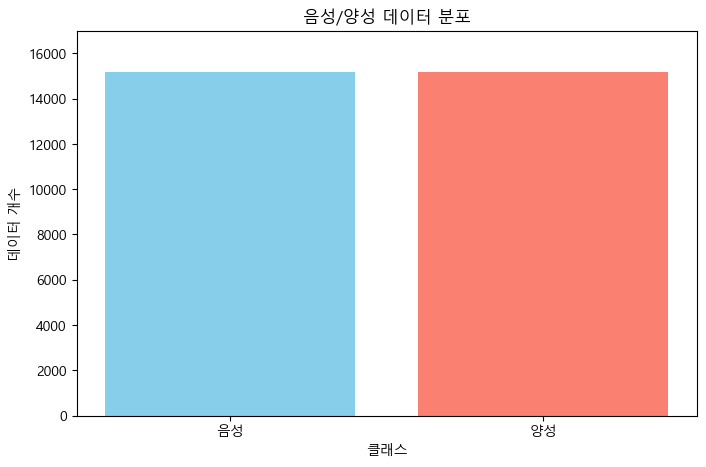

클래스 0: W 평균 - 0.0003, G 평균 - 0.9972, B 평균 - 0.0026
클래스 0: W 중앙값 - 0.0000, G 중앙값 - 1.0000, B 중앙값 - 0.0000
클래스 0: W 표준편차 - 0.0042, G 표준편차 - 0.0139, B 표준편차 - 0.0110
32.13979202316704
3.211267605633803
클래스 1: W 평균 - 0.2002, G 평균 - 0.6481, B 평균 - 0.1517
클래스 1: W 중앙값 - 0.0000, G 중앙값 - 1.0000, B 중앙값 - 0.0000
클래스 1: W 표준편차 - 0.3568, G 표준편차 - 0.4582, B 표준편차 - 0.3352
1902.694431630972
2511.156441515651


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import torch
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
from scipy.stats import pearsonr

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 구조 이해 및 샘플링 확인 (EDA)
def perform_eda(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]

    # 라벨별 데이터 개수 확인
    unique_labels, counts = np.unique(labels, return_counts=True)

    # 막대 그래프 시작
    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, tick_label=['음성', '양성'], color=['skyblue', 'salmon'])
    plt.xlabel('클래스')
    plt.ylabel('데이터 개수')
    plt.title('음성/양성 데이터 분포')
    plt.ylim(0,17000)
    plt.show()
    for label in np.unique(labels):
        label_items = [item[0] for item in dataset if item[1] == label]
        w_means = []
        g_means = []
        b_means = []
        w_medians = []
        g_medians = []
        b_medians = []
        w_stds = []
        g_stds = []
        b_stds = []

        w_count =[]
        g_count = []
        b_count = []
        
        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            r_channel = img_array[0].flatten()
            g_channel = img_array[1].flatten()
            b_channel = img_array[2].flatten()

            # 흰색 조건: 모든 RGB 값이 0.85 이상인 경우 1, 그렇지 않으면 0
            w_channel = np.where((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85), 1, 0)

            # 블랙 조건: 모든 RGB 값이 0.15 이하이며 흰색 조건을 만족하지 않는 경우 1, 그렇지 않으면 0
            b_channel = np.where((r_channel <= 0.15) & (g_channel <= 0.15) & (b_channel <= 0.15) & (w_channel == 0), 1, 0)

            # 회색 조건: 흰색과 블랙 조건을 만족하지 않는 경우 1, 그렇지 않으면 0
            g_channel = np.where((w_channel == 0) & (b_channel == 0), 1, 0)

            w_means.append(np.mean(w_channel.flatten()))
            g_means.append(np.mean(g_channel.flatten()))
            b_means.append(np.mean(b_channel.flatten()))

            w_count.append(np.sum(w_channel.flatten()))
            g_count.append(np.sum(g_channel.flatten()))
            b_count.append(np.sum(b_channel.flatten()))
           
            w_medians.append(np.median(w_channel.flatten()))
            g_medians.append(np.median(g_channel.flatten()))
            b_medians.append(np.median(b_channel.flatten()))

            w_stds.append(np.std(w_channel.flatten()))
            g_stds.append(np.std(g_channel.flatten()))
            b_stds.append(np.std(b_channel.flatten()))
          

        print(f"클래스 {label}: W 평균 - {np.mean(w_means):.4f}, G 평균 - {np.mean(g_means):.4f}, B 평균 - {np.mean(b_means):.4f}")
        print(f"클래스 {label}: W 중앙값 - {np.median(w_medians):.4f}, G 중앙값 - {np.median(g_medians):.4f}, B 중앙값 - {np.median(b_medians):.4f}")
        print(f"클래스 {label}: W 표준편차 - {np.mean(w_stds):.4f}, G 표준편차 - {np.mean(g_stds):.4f}, B 표준편차 - {np.mean(b_stds):.4f}")
        
        print(np.mean(b_count))
        print(np.mean(w_count))

perform_eda(dataset)
   


클래스 0: W 평균 - 0.0003, G 평균 - 0.9972, B 평균 - 0.0026
클래스 0: W 중앙값 - 0.0000, G 중앙값 - 1.0000, B 중앙값 - 0.0000
[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 4, 8, 24, 35, 14, 50, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 62, 120, 2, 21, 38, 2, 33, 7, 60, 10, 64, 5, 0, 117, 80, 37, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 384, 0, 114, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 10, 0, 0, 0, 0, 59, 0, 13, 0, 0, 0, 0, 0, 

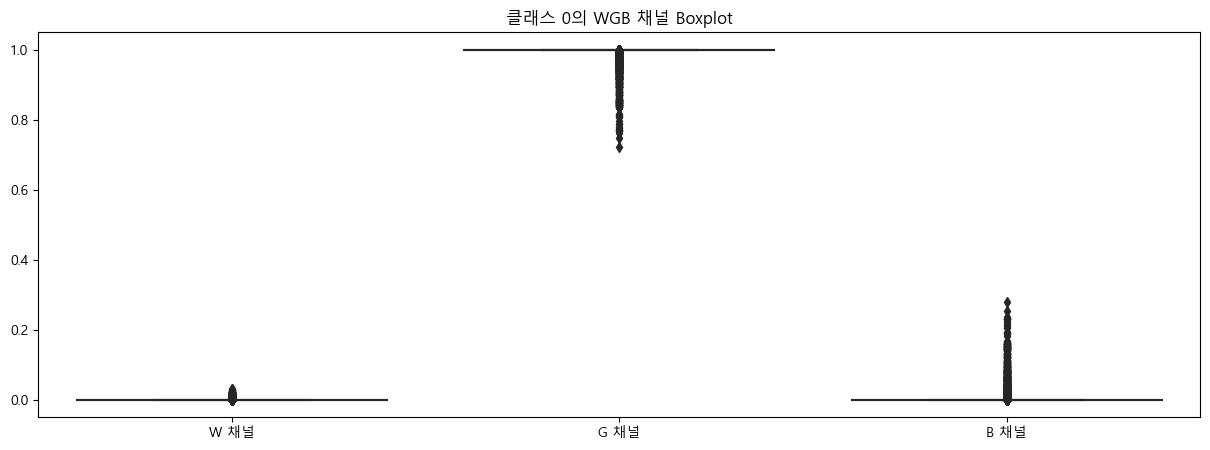

12544
12544


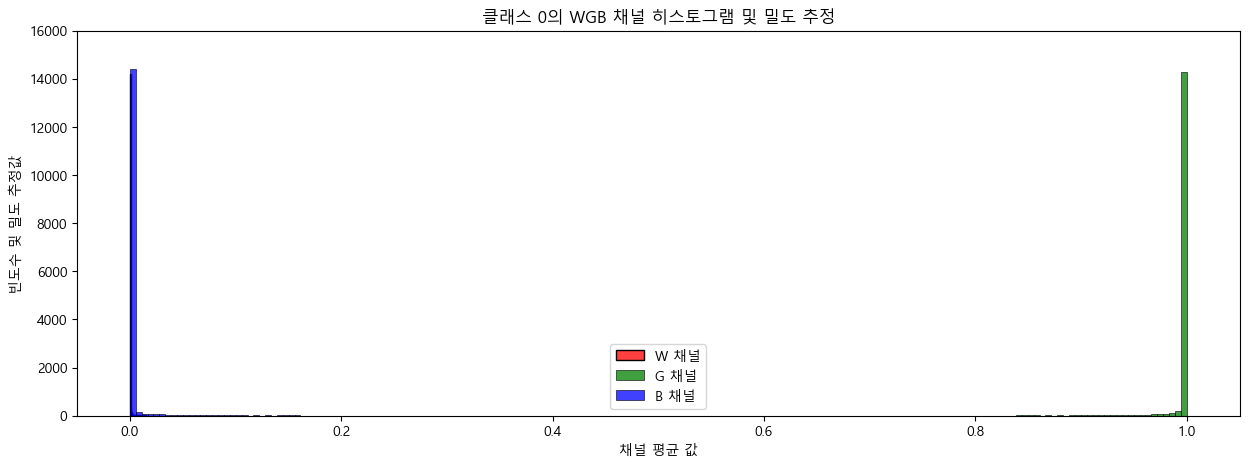

2024-11-12 23:19:51,696 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001DBB404ECC8>


클래스 0의 WGB 채널 간 상관계수:
          W 채널 평균   G 채널 평균   B 채널 평균
W 채널 평균  1.000000 -0.181558  0.085525
G 채널 평균 -0.181558  1.000000 -0.995305
B 채널 평균  0.085525 -0.995305  1.000000



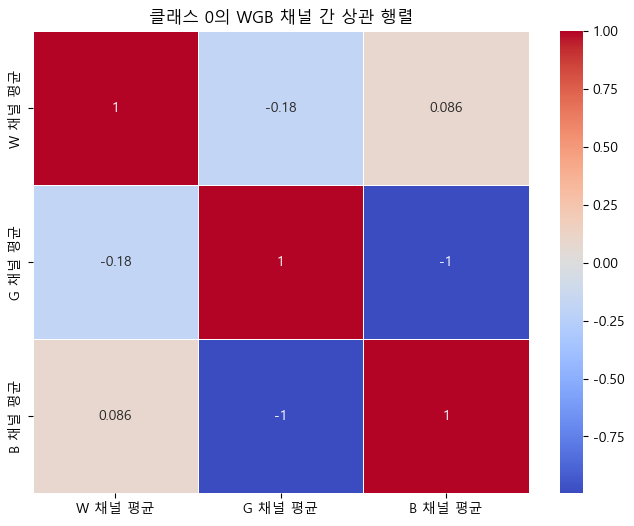

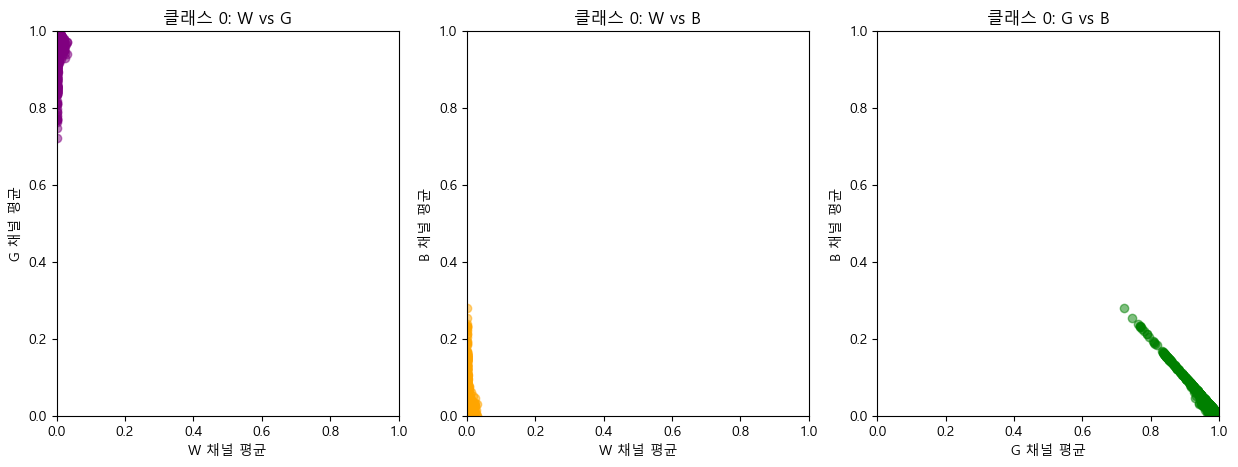

2024-11-12 23:19:52,535 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001DBB6507888>


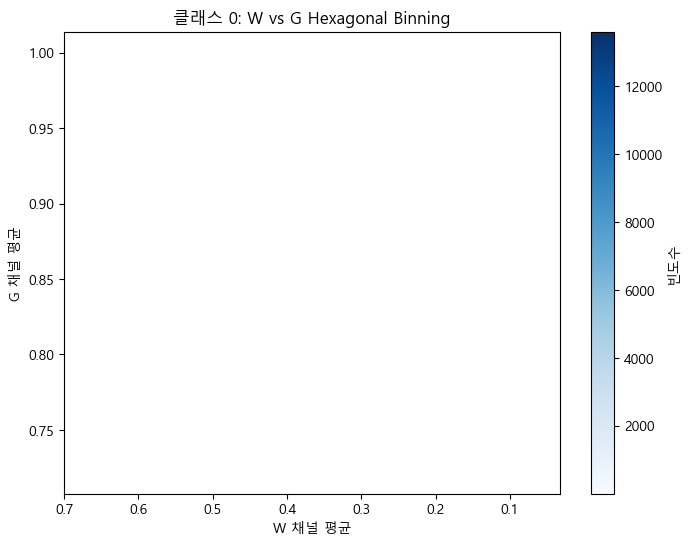

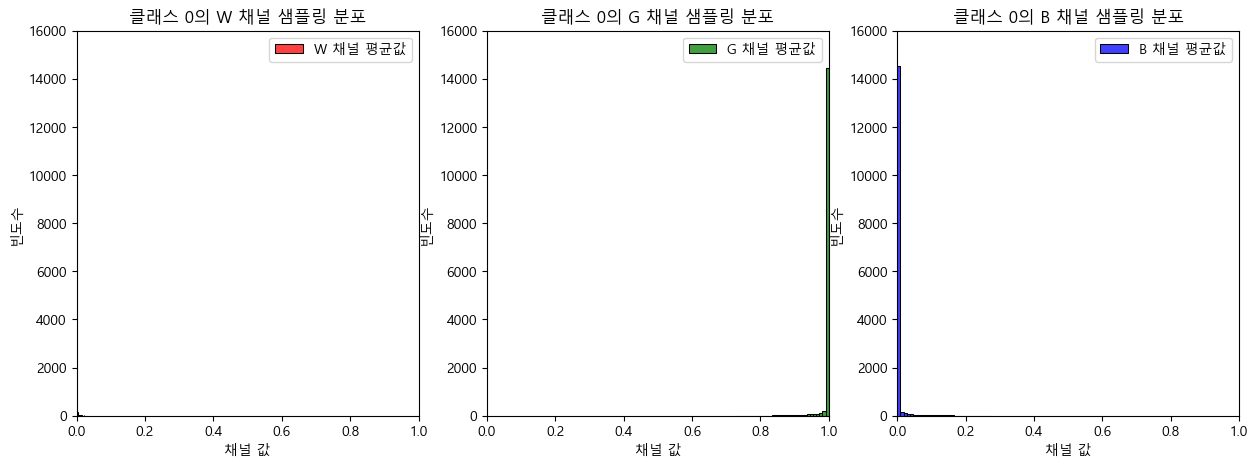

클래스 0의 W 채널 평균: 0.0003, 표준 오차: 0.0000
클래스 0의 G 채널 평균: 0.9972, 표준 오차: 0.0001
클래스 0의 B 채널 평균: 0.0026, 표준 오차: 0.0001
클래스 0의 W 채널 95% 신뢰 구간: (0.0002, 0.0003)
클래스 0의 G 채널 95% 신뢰 구간: (0.9969, 0.9974)
클래스 0의 B 채널 95% 신뢰 구간: (0.0023, 0.0028)


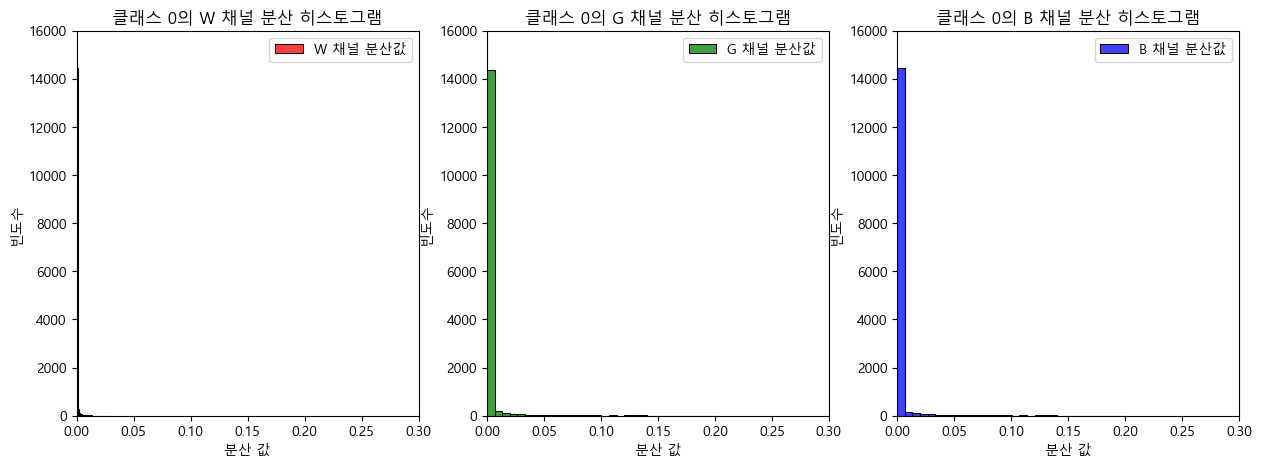

클래스 0의 W 평균: 0.0003, 표준 오차: 0.0000
클래스 0의 G 평균: 0.9972, 표준 오차: 0.0001
클래스 0의 B 평균: 0.0026, 표준 오차: 0.0001
클래스 1: W 평균 - 0.2002, G 평균 - 0.6481, B 평균 - 0.1517
클래스 1: W 중앙값 - 0.0000, G 중앙값 - 1.0000, B 중앙값 - 0.0000
[344, 1813, 1819, 942, 961, 1293, 4179, 1255, 181, 3334, 4097, 1313, 2049, 2231, 4458, 1619, 623, 3200, 1104, 396, 361, 390, 319, 1138, 67, 1722, 616, 652, 2273, 566, 660, 2237, 3434, 3595, 2776, 1232, 4493, 4263, 2635, 277, 637, 4737, 3594, 2695, 1455, 4, 2580, 1642, 5144, 816, 105, 2838, 4389, 2557, 1255, 2783, 1079, 2998, 2071, 1424, 2521, 4092, 5908, 4591, 2780, 2617, 2971, 1195, 1233, 3436, 1894, 1649, 1159, 3363, 2, 25, 265, 194, 4494, 2478, 2079, 4570, 1453, 5185, 4604, 4334, 2475, 4152, 6371, 1295, 3970, 3590, 4876, 2019, 1754, 2723, 3780, 2088, 325, 265, 394, 50, 992, 1481, 2234, 2304, 741, 2134, 2740, 3353, 3374, 3194, 1903, 0, 3131, 1256, 2879, 1562, 1300, 4237, 2500, 2022, 2193, 661, 869, 3235, 14, 1085, 1104, 1283, 3345, 3647, 1262, 362, 1784, 1733, 190, 1366, 365, 3

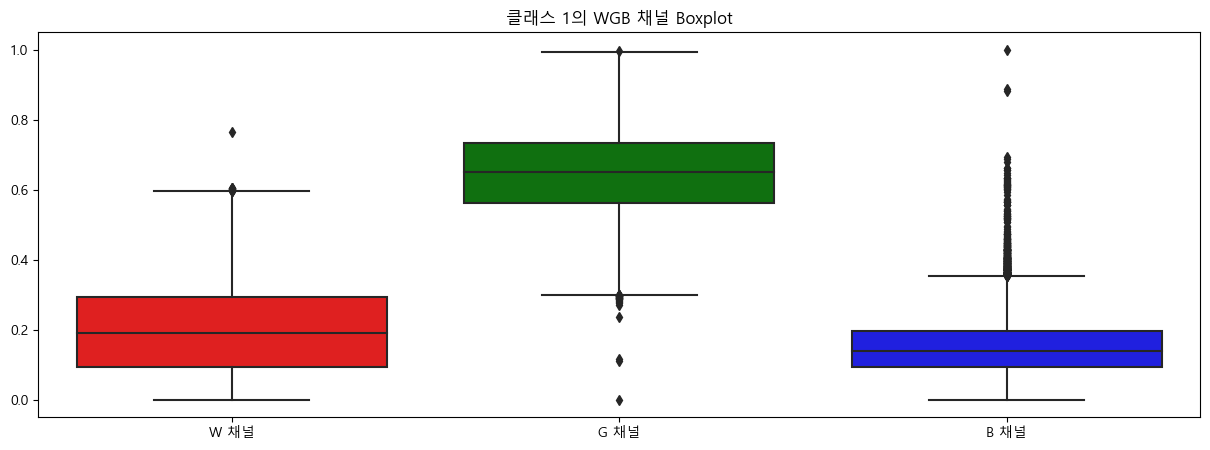

12544
12544


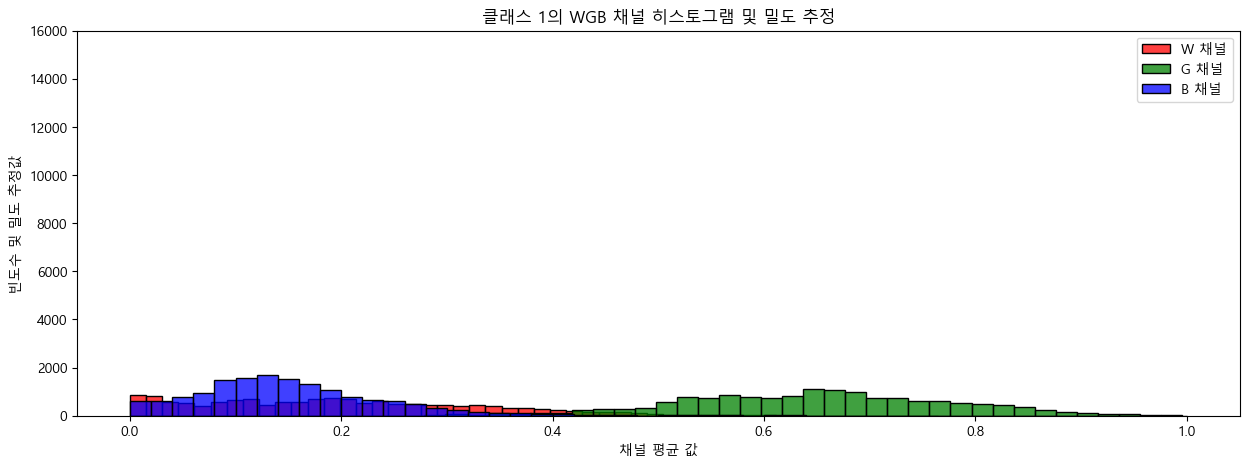

2024-11-12 23:20:06,286 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001DBB31E58C8>


클래스 1의 WGB 채널 간 상관계수:
          W 채널 평균   G 채널 평균   B 채널 평균
W 채널 평균  1.000000 -0.765105 -0.416048
G 채널 평균 -0.765105  1.000000 -0.267210
B 채널 평균 -0.416048 -0.267210  1.000000



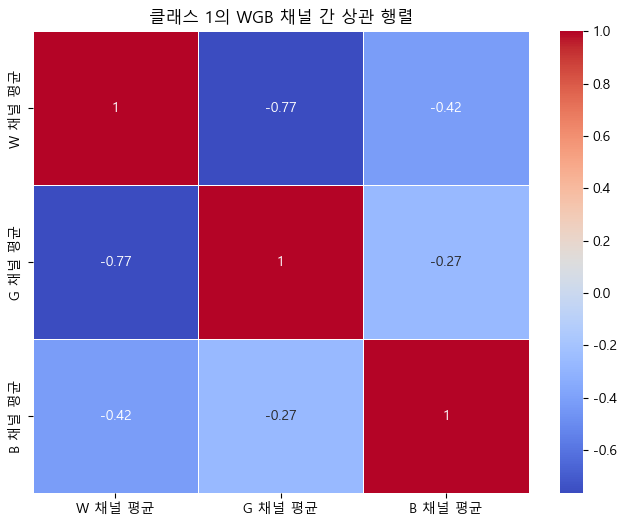

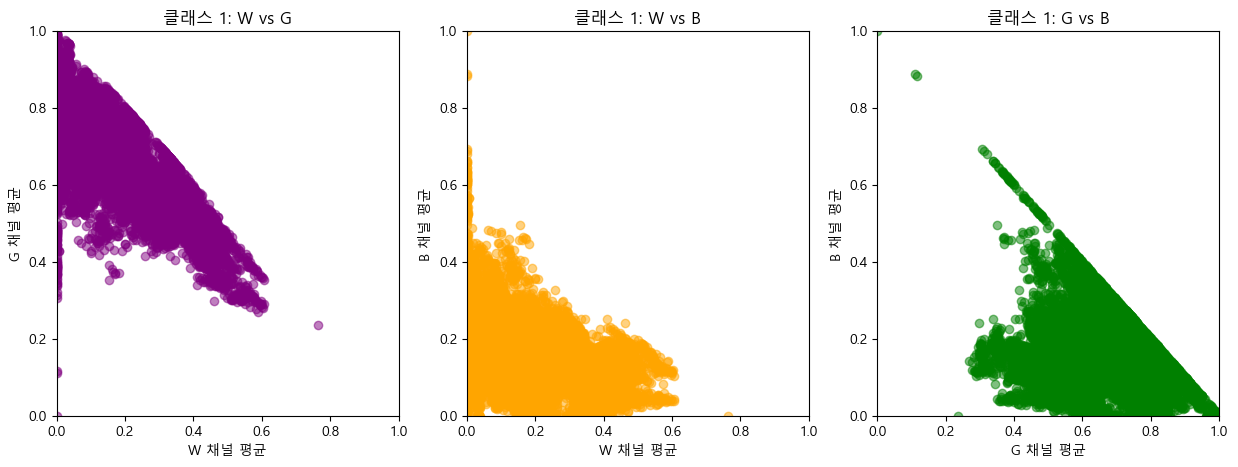

2024-11-12 23:20:07,161 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001DBB0F47A08>


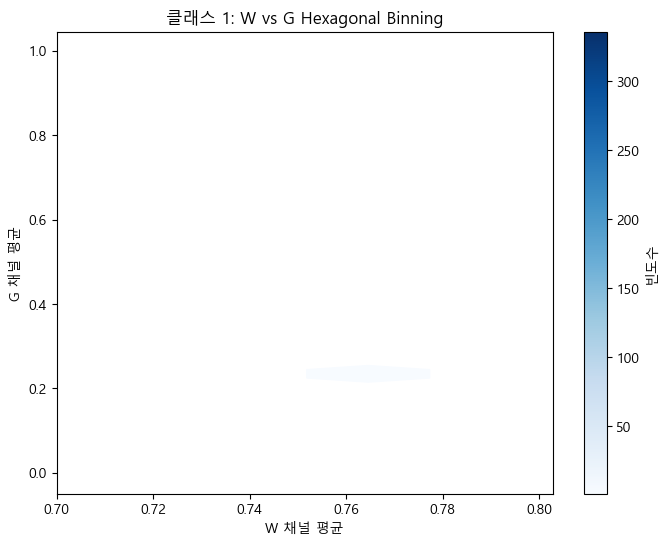

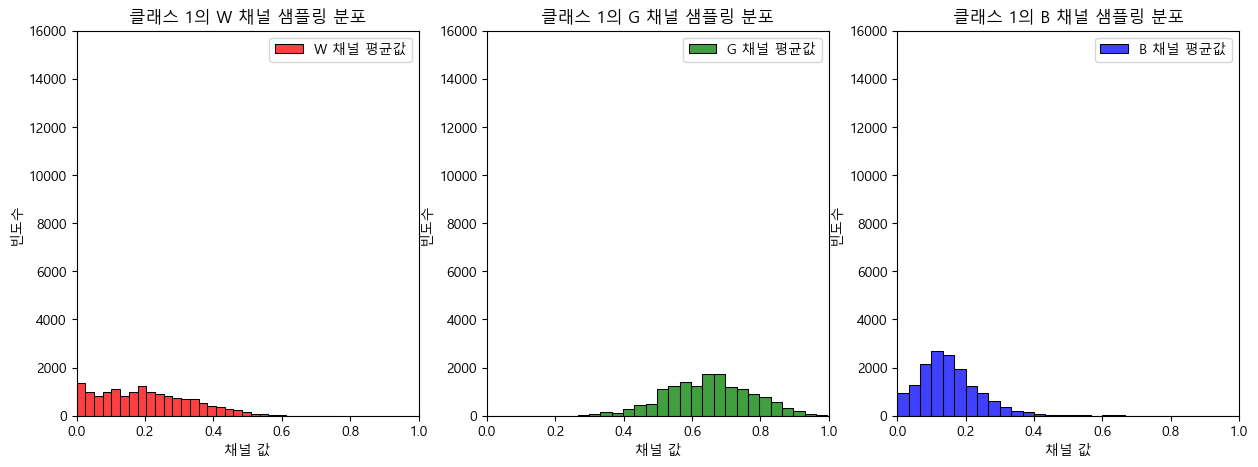

클래스 1의 W 채널 평균: 0.2002, 표준 오차: 0.0011
클래스 1의 G 채널 평균: 0.6481, 표준 오차: 0.0010
클래스 1의 B 채널 평균: 0.1517, 표준 오차: 0.0007
클래스 1의 W 채널 95% 신뢰 구간: (0.1981, 0.2023)
클래스 1의 G 채널 95% 신뢰 구간: (0.6461, 0.6501)
클래스 1의 B 채널 95% 신뢰 구간: (0.1503, 0.1531)


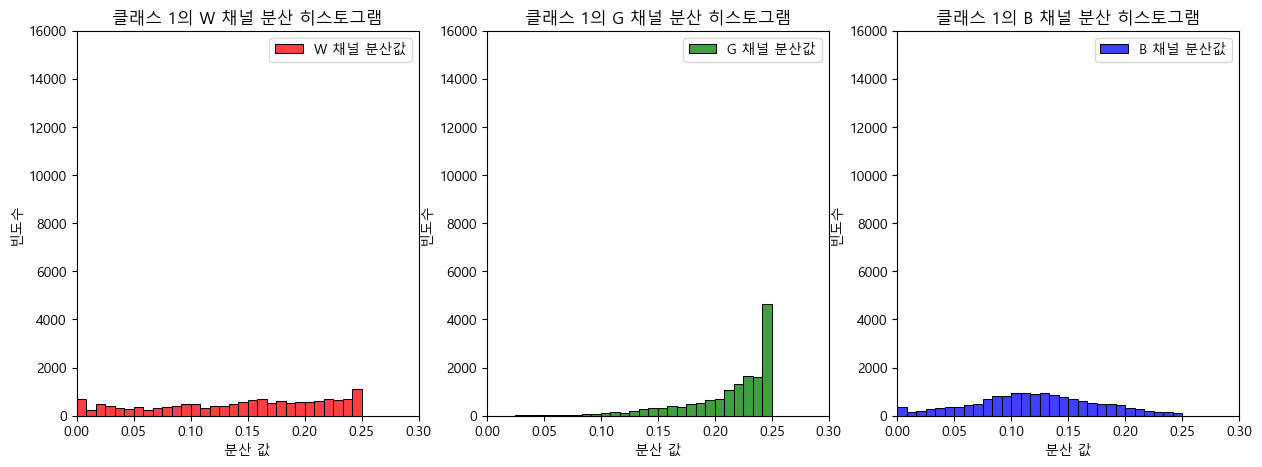

클래스 1의 W 평균: 0.2002, 표준 오차: 0.0011
클래스 1의 G 평균: 0.6481, 표준 오차: 0.0010
클래스 1의 B 평균: 0.1517, 표준 오차: 0.0007


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import torch
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
from scipy.stats import pearsonr, norm, probplot, ttest_ind, f_oneway, chi2_contingency
from tqdm import tqdm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 통계적 실험과 유의성 검정 수행
def perform_statistical_experiments_and_tests(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 흰색(W) 및 흰색이 아닌(NW) 채널 평균 및 분산 추출
    label_data = {}
    observed_means = {}
    observed_variances = {}
    for label in np.unique(labels):
        label_items = [item[0] for item in dataset if item[1] == label]
        w_means = []
        g_means = []
        b_means = []
        w_medians = []
        g_medians = []
        b_medians = []
        w_stds = []
        g_stds = []
        b_stds = []
        w_variances = []
        g_variances = []
        b_variances = []
        w_count =[]

        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            r_channel = img_array[0].flatten()
            g_channel = img_array[1].flatten()
            b_channel = img_array[2].flatten()

            # 흰색 조건: 모든 RGB 값이 0.85 이상인 경우 1, 그렇지 않으면 0
            w_channel = np.where((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85), 1, 0)

            # 블랙 조건: 모든 RGB 값이 0.15 이하이며 흰색 조건을 만족하지 않는 경우 1, 그렇지 않으면 0
            b_channel = np.where((r_channel <= 0.15) & (g_channel <= 0.15) & (b_channel <= 0.15) & (w_channel == 0), 1, 0)

            # 회색 조건: 흰색과 블랙 조건을 만족하지 않는 경우 1, 그렇지 않으면 0
            g_channel = np.where((w_channel == 0) & (b_channel == 0), 1, 0)

            w_count.append(np.sum(w_channel.flatten()))
            
            w_means.append(np.mean(w_channel.flatten()))
            g_means.append(np.mean(g_channel.flatten()))
            b_means.append(np.mean(b_channel.flatten()))
           
            w_medians.append(np.median(w_channel.flatten()))
            g_medians.append(np.median(g_channel.flatten()))
            b_medians.append(np.median(b_channel.flatten()))

            w_stds.append(np.std(w_channel.flatten()))
            g_stds.append(np.std(g_channel.flatten()))
            b_stds.append(np.std(b_channel.flatten()))

            w_variances.append(np.var(w_channel.flatten()))
            g_variances.append(np.var(g_channel.flatten()))
            b_variances.append(np.var(b_channel.flatten()))

        print(f"클래스 {label}: W 평균 - {np.mean(w_means):.4f}, G 평균 - {np.mean(g_means):.4f}, B 평균 - {np.mean(b_means):.4f}")
        print(f"클래스 {label}: W 중앙값 - {np.median(w_medians):.4f}, G 중앙값 - {np.median(g_medians):.4f}, B 중앙값 - {np.median(b_medians):.4f}")
        print(w_count)
        label_data[label] = {'W': w_means,'g':g_means, 'b': b_means}
        observed_means[label] = {'W': np.mean(w_means), 'b': np.mean(b_means)}
    # Boxplot 시각화 (클래스별 WGB 채널 평균을 추출하여 박스플롯 생성)

        plt.figure(figsize=(15, 5))
        sns.boxplot(data=[w_means, g_means, b_means], palette=['r', 'g', 'b'])
        plt.xticks([0, 1, 2], ['W 채널', 'G 채널', 'B 채널'])
        plt.title(f'클래스 {label}의 WGB 채널 Boxplot')
       
        plt.show()
        print(len(r_channel))
        print(len(w_channel))
    # 빈도 테이블과 히스토그램 및 밀도 추정 (클래스별 WGB 채널 히스토그램 및 밀도 추정)
    
        plt.figure(figsize=(15, 5))
        sns.histplot(w_means, bins=50, color='r', kde=False, label='W 채널')
        sns.histplot(g_means, bins=50, color='g', kde=False, label='G 채널')
        sns.histplot(b_means, bins=50, color='b', kde=False, label='B 채널')
        plt.ylim(0,16000)
        plt.xlabel('채널 평균 값')
        plt.ylabel('빈도수 및 밀도 추정값')
        plt.title(f'클래스 {label}의 WGB 채널 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()

    # WGB 채널 간 상관관계 (Correlation)
 
        
        df = pd.DataFrame({'W 채널 평균': w_means, 'G 채널 평균': g_means, 'B 채널 평균': b_means})
        corr_matrix = df.corr()
        print(f"클래스 {label}의 WGB 채널 간 상관계수:\n{corr_matrix}\n")

        # 상관 행렬 시각화
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'클래스 {label}의 WGB 채널 간 상관 행렬')
        plt.show()

    # WGB 채널 간 산점도 (Scatterplots)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.scatter(w_means, g_means, alpha=0.5, color='purple')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xlabel('W 채널 평균')
        plt.ylabel('G 채널 평균')
        plt.title(f'클래스 {label}: W vs G')

        plt.subplot(1, 3, 2)
        plt.scatter(w_means, b_means, alpha=0.5, color='orange') 
        plt.xlabel('W 채널 평균')
        plt.ylabel('B 채널 평균')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.title(f'클래스 {label}: W vs B')

        plt.subplot(1, 3, 3)
        plt.scatter(g_means, b_means, alpha=0.5, color='green')
        plt.xlabel('G 채널 평균')
        plt.ylabel('B 채널 평균')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.title(f'클래스 {label}: G vs B')
        plt.show()

    # WGB 채널 간 Hexagonal binning 시각화

        plt.figure(figsize=(8, 6))
        plt.hexbin(w_means, g_means, gridsize=30, cmap='Blues', mincnt=1)
        plt.xlim(0.7)
        plt.xlabel('W 채널 평균')
        plt.ylabel('G 채널 평균')
        plt.title(f'클래스 {label}: W vs G Hexagonal Binning')
        plt.colorbar(label='빈도수')
        plt.show()  


    
    # 라벨별 데이터에서 WGB 채널 평균 및 샘플링 분포 시각화

        # WGB 채널 평균 분포 시각화
        plt.figure(figsize=(15, 5))
        for i, (means, color, channel) in enumerate(zip([w_means, g_means, b_means], ['r', 'g', 'b'], ['W 채널', 'G 채널', 'B 채널'])):
            plt.subplot(1, 3, i + 1)
            sns.histplot(means, bins=30, kde=False, color=color, label=f'{channel} 평균값')
            plt.xlim(0,1)
            plt.ylim(0,16000)
            plt.xlabel('채널 값')
            plt.ylabel('빈도수')
            plt.title(f'클래스 {label}의 {channel} 샘플링 분포')
            plt.legend()
        plt.show()

        # 평균 및 표준 오차 계산
        for means, channel in zip([w_means, g_means, b_means], ['W 채널', 'G 채널', 'B 채널']):
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            print(f"클래스 {label}의 {channel} 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
    
        # 95% 신뢰 구간 계산
        for channel, means in zip(['W 채널', 'G 채널', 'B 채널'], [w_means, g_means, b_means]):
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            ci_lower = sample_mean - 1.96 * sample_std_error
            ci_upper = sample_mean + 1.96 * sample_std_error
            print(f"클래스 {label}의 {channel} 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")


        # 분산 히스토그램 생성
        plt.figure(figsize=(15, 5))
        for i, (variances, color, channel) in enumerate(zip([w_variances, g_variances, b_variances], ['r', 'g', 'b'], ['W 채널', 'G 채널', 'B 채널'])):
            plt.subplot(1, 3, i + 1)
            sns.histplot(variances, bins=30, kde=False, color=color, label=f'{channel} 분산값')
            plt.xlim(0,0.3)
            plt.ylim(0,16000)
            plt.xlabel('분산 값')
            plt.ylabel('빈도수')
            plt.title(f'클래스 {label}의 {channel} 분산 히스토그램')
            plt.legend()
        
        plt.show()

        # 기존의 t-검정 수행 및 결과 출력 코드 ...
        # 예시로 추가
        for channel, means in zip(['W', 'G', 'B'], [w_means, g_means, b_means]):
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            print(f"클래스 {label}의 {channel} 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")

  
# 통계적 실험과 유의성 검정 수행
perform_statistical_experiments_and_tests(dataset)

# 모델 설정

# 모델명: GoogleNet

In [11]:
class Inception(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수, default = 3
    use_auxiliary (boolean) : Auxiliary의 사용 여부, default = True
    num_classes (integer)   : Input dataset 의 class(label)의 개수, default = 10
    
    GoogleNet 모형의 전체 구조 구현
    '''
    def __init__(self,num_classes, in_channels=3, use_auxiliary=True):
        super(Inception, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1)
        
        self.dropout = nn.Dropout(0.60)
        self.linear = nn.Linear(4096, num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None
        
        x = self.conv1(x) # 
        x = self.maxpool(x) # 
        x = self.conv2(x) # 
        x = self.maxpool(x) # 
        
        x = self.inception3a(x) # 
        x = self.inception3b(x) # 
        x = self.maxpool(x) # 
    
        x = self.inception4a(x) # 
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        
        x = self.linear(x)
        
        return x, y, z

In [12]:
class ConvBlock(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수
    out_channels (integer)  : Output dataset 의 channel 수
    kernel_size (integer) : Convolution Layer의 kernel 크기
    
    GoogleNet 모형의 Inception Module에 사용되는 Convolution Block을 구현
    '''
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) 
        self.ReLU = nn.ReLU() #activation function 교체
        
    def forward(self, x):
        return self.ReLU(self.bn(self.conv(x)))

In [13]:
class InceptionBlock(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수
    num_1x1(integer)        : Filter의 크기가 1X1인 Convolution Block(self.one_by_one)의 출력 channel 수
    num_3x3_red(integer)    : Filter의 크기가 1X1인 Convolution Block(self.tree_by_three_red)의 출력 channel 수
    num_3x3(integer)        : Filter의 크기가 3X3인 Convolution Block(self.tree_by_three)의 출력 channel 수
    num_5x5_red(integer)    : Filter의 크기가 1X1인 Convolution Block(self.five_by_five_red)의 출력 channel 수
    num_5x5(integer)        : Filter의 크기가 5X5인 Convolution Block(self.five_by_five)의 출력 channel 수
    num_pool_proj(integer)  : Filter의 크기가 1X1인 Convolution Block(self.pool_proj)의 출력 channel 수
    
    GoogleNet 모형의 Inception Module을 구현
    '''
    def __init__(self, in_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()
        
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.one_by_one = ConvBlock(in_channels, num_1x1, kernel_size=1)
        
        self.tree_by_three_red = ConvBlock(in_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        
        self.five_by_five_red = ConvBlock(in_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(in_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [14]:
class Auxiliary(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수          
    num_classes (integer)   : Input dataset 의 class(label)의 개수 
    
    GoogleNet 모형에서 train dataset 학습시 사용되는 Auxiliary Classifier를 구현
    '''
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(0.6)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.ReLU(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
class GoogleNetModel(nn.Module):
    '''
    train_dataset (dataset)         : 모형 학습에서 train dataset 로 사용할 데이터 셋
    val_dataset (dataset)           : 모형 학습에서 validation dataset 로 사용할 데이터 셋
    epoch (integer)              : 학습을 반복할 횟수
    learning_rate (float)        : 모형 학습에서 사용할 learning_rate
    batch_size (integer)         : 한 번 학습에 사용할 이미지의 개수
    loader_num_workers (integer) : DataLoader에서 사용할 코어의 개수
        
    GoogleNet 모형을 학습시키는 일련의 과정을 구현
    '''
    def __init__(self, train_dataset, val_dataset, num_classes, epoch, learning_rate, batch_size, loader_num_workers):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset   
        self.num_classes = num_classes
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loader_num_workers = loader_num_workers
        self.patience_i = int(min(np.ceil(epoch*1), 10))
        
        
    def GoogleNetTrain(self):
        model = Inception(num_classes = self.num_classes).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=self.patience_i, verbose=True)
        
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.loader_num_workers)
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.loader_num_workers)
        dataloaders = {"train": train_loader, "val": val_loader}
                
        since = time.time()
        train_acc_history = []
        train_loss_history = []
        val_acc_history = []
        val_loss_history = []
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        use_auxiliary=True
        loss_sample=[]

        for i in range(self.epoch):
            epoch_time = time.time()
            print('Epoch {}/{}'.format(i+1, self.epoch), '(', datetime.datetime.now(), ')')
            logger.info('Epoch {}/{}'.format(i+1,self.epoch))
            print('-' * 10)
            logger.info('-'*10)

            for phase in ['train', 'val']: # Each epoch has a training and validation phase
                if phase == 'train':
                    logger.info('Model Training을 진행합니다.')
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    logger.info('Model을 validation을 진행합니다')

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]: # Iterate over dataset

                    inputs = inputs.to(self.device) #tensor data

                    labels = labels.to(self.device) #label값

                    optimizer.zero_grad() # Zero the parameter gradients

                    with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train

                        if phase == 'train': # Backward + optimize only if in training phase
                            if use_auxiliary:
                                outputs, aux1, aux2 = model(inputs)
                                loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                                loss_sample.append(loss)
                            else:
                                outputs, _, _ = model(inputs)
                                loss = criterion(outputs, labels)
                                loss_sample.append(loss)

                            _, preds = torch.max(outputs, 1)
                            loss.backward() #backpropagation
                            optimizer.step() #가중치 업데이트

                        if phase == 'val':
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            loss_sample.append(loss)
                            _, preds = torch.max(outputs, 1)

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'val': # Adjust learning rate based on val loss
                    lr_scheduler.step(epoch_loss)

                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), '(', datetime.datetime.now(), ')')
                #logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                e_time = time.time() - epoch_time

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_num = i+1
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(float(epoch_acc))
                    val_loss_history.append(float(epoch_loss))
                if phase == 'train':
                    train_acc_history.append(float(epoch_acc))
                    train_loss_history.append(float(epoch_loss))

            print('Epoch Time : {:.0f}m {:.0f}s'.format(e_time//60, e_time%60), datetime.datetime.now(), '(', datetime.datetime.now(), ')\n')
            logger.info('Epoch Time : {:.0f}m {:0f}s'.format(e_time//60, e_time%60))

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), '(', datetime.datetime.now(), ')')
        logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Model is {0}'.format(best_num), '(', datetime.datetime.now(), ')')
        logger.info('Best Model is {0}'.format(best_num))
        print('Best val Acc: {:4f}'.format(best_acc), '(', datetime.datetime.now(), ')')
        logger.info('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        
        return model, self.epoch, train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Model Training 진행

In [ ]:
print('GoogleNet train 시작', '(', datetime.datetime.now(), ')')
#logger.info('GoogleNet train 시작')

model, epoch, train_loss_history, train_acc_history, val_loss_history, val_acc_history = GoogleNetModel(train_dataset = [i[0:2] for i in traindataset],
                                                                                               val_dataset = [i[0:2] for i in valdataset],
                                                                                               num_classes = 2, epoch = 10, 
                                                                                               learning_rate = 0.1, batch_size = 32,
                                                                                               loader_num_workers = 1).GoogleNetTrain()
# if (os.path.exists('./models')==False):
#     os.makedirs('./models')
# torch.save(model, f'./models/GoogleNet.pt')
logger.info('학습을 완료한 GoogleNet모델을 저장하였습니다.')
# torch.save(model.state_dict(), f'./models/GoogleNet_stat.pt')
logger.info('학습을 완료한 GoogleNet모델의 파라미터들을 저장하였습니다.')

GoogleNet train 시작 ( 2022-12-27 10:20:16.491053 )
cuda


2022-12-27 10:20:21,073 - root - INFO - Epoch 1/10
2022-12-27 10:20:21,074 - root - INFO - ----------
2022-12-27 10:20:21,074 - root - INFO - Model Training을 진행합니다.


Epoch 1/10 ( 2022-12-27 10:20:21.073544 )
----------


# Model Test 진행

In [23]:
random_seed=42
try:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f'{device}로 Test를 진행중입니다.')
        
    else:
        device = torch.device('cpu')
        logger.info(f'{device}로 Test를 진행중입니다.')
        
except:
    device = torch.device('cpu')
    
Image.MAX_IMAGE_PIXELS = None
try:
    torch.backends.cudnn.deterministic = True    
    torch.backends.cudnn.benchmark = False 
except:
    pass
np.random.seed(random_seed)
try:
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
except:
    pass

#### Test Accuracy for classes
model = torch.load('./models/GoogleNet.pt', map_location=device)
logger.info('학습한 GoogleNet모델을 Load합니다.')
model.load_state_dict(torch.load('./models/GoogleNet_stat.pt', map_location=device))
logger.info('각 레이어에 해당하는 가중치 정보를 가져옵니다.')
model = model.to(device)

test_loader = DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0)

label_list = list()
prediction_list = list()

#### Print Result
print('GoogleNet Test 결과 출력', '(', datetime.datetime.now(), ')')
logger.info('GoogleNet Test 결과 출력')


classes = ['LA_NEG','LA_POS']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

print(f'{device}로 결과를 출력중입니다. cpu로 계산할 경우 시간이 오래 걸리니 기다려주세요.')

model.eval()
#logger.info('GoogleNet 모델의 Test를 진행합니다.')
with torch.no_grad():
    for data in test_loader:
        images, labels, _ = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs[0], 1)    

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            label_list.append(label.tolist())
            prediction_list.append(prediction.tolist())
mean = 0
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]

    print(f'Accuracy for class : {classname:7s} is {accuracy:.2f} %', '(', datetime.datetime.now(), ')')
    logger.info(f'Accuracy for class : {classname:7s} is {accuracy:2f} %')
    mean += accuracy
print(f'\nTotal classes : {mean/len(classes):.2f} %', '(', datetime.datetime.now(), ')')
logger.info(f'Total classes : {mean/len(classes):.2f} %')

2022-12-26 14:06:47,454 - root - INFO - cuda로 Test를 진행중입니다.
2022-12-26 14:06:48,034 - root - INFO - 학습한 GoogleNet모델을 Load합니다.
2022-12-26 14:06:48,246 - root - INFO - 각 레이어에 해당하는 가중치 정보를 가져옵니다.
2022-12-26 14:06:48,250 - root - INFO - GoogleNet Test 결과 출력


GoogleNet Test 결과 출력 ( 2022-12-26 14:06:48.250286 )
cuda로 결과를 출력중입니다. cpu로 계산할 경우 시간이 오래 걸리니 기다려주세요.


2022-12-26 14:07:09,596 - root - INFO - Accuracy for class : LA_NEG  is 99.695870 %
2022-12-26 14:07:09,597 - root - INFO - Accuracy for class : LA_POS  is 94.731679 %
2022-12-26 14:07:09,597 - root - INFO - Total classes : 97.21 %


Accuracy for class : LA_NEG  is 99.70 % ( 2022-12-26 14:07:09.596889 )
Accuracy for class : LA_POS  is 94.73 % ( 2022-12-26 14:07:09.597942 )

Total classes : 97.21 % ( 2022-12-26 14:07:09.597942 )


# 유효성 증빙서류 

1. 개별 결과값

2. confusion matrix

In [18]:
# 1. 개별 결과값 Test data set

test_ID=[]
for i in range(len(testdataset)):
    ID=testdataset[i][2]
    test_ID.append(ID)

    
test_ID=pd.DataFrame(test_ID)
label_data=pd.DataFrame(label_list)
pred_data=pd.DataFrame(prediction_list)

df_list=pd.concat([test_ID,label_data],axis=1)
df_list=pd.concat([df_list,pred_data],axis=1)
df_list.columns=['file_name','label','prediction']

logger.info(f'문제 당 개별 결과값을 출력합니다.')
logger.info(f'{df_list}')
df_list

# 문제당 개별 결과값 저장
logger.info(f'문제 당 개별 결과값을 {save_path}에 저장합니다.')
df_list.to_csv(save_path+'/'+'문제 당 개별 결과값.csv',encoding='cp949',index=False)

2022-12-26 12:46:21,932 - root - INFO - 문제 당 개별 결과값을 출력합니다.
2022-12-26 12:46:21,949 - root - INFO -                                file_name  label  prediction
0      01_1_R_LA_NA_20220720_05_1000.jpg      0           0
1      01_1_R_LA_NA_20220714_07_1379.jpg      0           0
2      01_1_R_LA_NA_20220714_02_1335.jpg      0           0
3      01_1_R_LA_NA_20220718_05_0139.jpg      0           0
4      01_2_R_LA_NA_20220721_02_0585.jpg      0           0
...                                  ...    ...         ...
20381  06_1_R_AA_NA_20221109_02_0914.jpg      1           1
20382  06_1_R_AA_NA_20221102_04_0641.jpg      1           1
20383  06_1_R_AA_NA_20221110_01_0602.jpg      1           1
20384  06_1_R_AA_NA_20221103_03_0267.jpg      1           1
20385  06_1_R_AA_NA_20221102_04_0028.jpg      1           1

[20386 rows x 3 columns]
2022-12-26 12:46:21,950 - root - INFO - 문제 당 개별 결과값을 C:/Users/user/Desktop/증빙서류에 저장합니다.


In [19]:
# 2. confusion matrix

cf=confusion_matrix(label_list, prediction_list)

cf=pd.DataFrame(cf).rename(index={0:'True_백묵병음성',1:'True_백묵병양성'}
                             ,columns={0:'Pred_백묵병음성',1:'pred_백묵병양성'})

logger.info(f'confusion matrix를 출력합니다. {cf}')
#계산할 때 사용된 값 저장 (Confusion matrix 기반 TP, FP, TN, FN)
cf.to_csv(save_path+'/'+'Confusion Matrix 기반 TP, FP, TN, FN(백묵병 분류 모델).csv',encoding='cp949')
logger.info(f'Counfusion matrix 기반 TP, FP, TN, FN값을 {save_path}에 저장합니다')

2022-12-26 12:46:25,772 - root - INFO - confusion matrix를 출력합니다.             Pred_백묵병음성  pred_백묵병양성
True_백묵병음성       10162          31
True_백묵병양성         537        9656
2022-12-26 12:46:25,774 - root - INFO - Counfusion matrix 기반 TP, FP, TN, FN값을 C:/Users/user/Desktop/증빙서류에 저장합니다
